In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from reachability.envs.workspace import Workspace2D
from reachability.envs.rotary_nlink import RotaryNLinkEnv
import time

## Testing environment setup

[[[-1.5707963267948966, -0.7853981633974483], [0.7853981633974483, 1.5707963267948966]], [[-1.5707963267948966, -1.0471975511965976], [1.0471975511965976, 1.5707963267948966]], [[-3.141592653589793, -0.7853981633974483], [0.7853981633974483, 1.5707963267948966]]]
(1, 6)


<Axes: title={'center': 'RotaryNLink (N=3)\nBase psi=36.3° | EE Delta=0.0000'}, xlabel='X (World)', ylabel='Y (World)'>

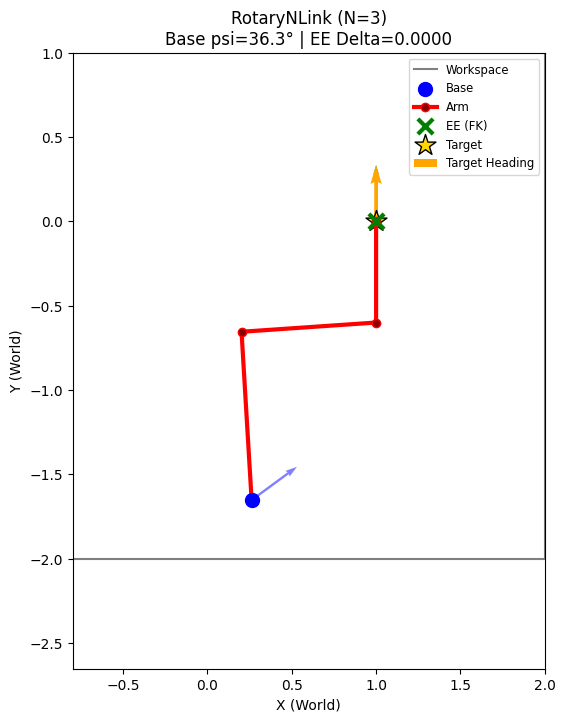

In [38]:
workspace = Workspace2D(-2, 2, -2, 2)
# link_lengths = np.array([1.0, 0.8, 0.6, 0.8, 1.0])
# joint_limits = [[[-np.pi/2, -np.pi/4], [np.pi/4, np.pi/2]], [[-np.pi/2, -np.pi/4], [np.pi/4, np.pi/2]], [[-np.pi/2, -np.pi/4], [np.pi/4, np.pi/2]], [[-np.pi/3, np.pi/2]], [[-np.pi/3, np.pi/2]]]
link_lengths = np.array([1.0, 0.8, 0.6])
joint_limits = [[[-np.pi/2, -np.pi/4], [np.pi/4, np.pi/2]], [[-np.pi/2, -np.pi/3], [np.pi/3, np.pi/2]], [[-np.pi, -np.pi/4], [np.pi/4, np.pi/2]]]
print(joint_limits)
env = RotaryNLinkEnv(workspace, link_lengths=link_lengths, joint_limits=joint_limits, n_links=3) #joint_limits=[[-np.pi, np.pi], [-np.pi, np.pi]],

rng = np.random.default_rng(0)
h_world = np.array([[1, 0, np.pi/2]], dtype=np.float32)
q_sample_world = env.sample_q(h_world, rng)

print(q_sample_world.shape)
env.plot(q_sample_world.flatten(), h_world.flatten())

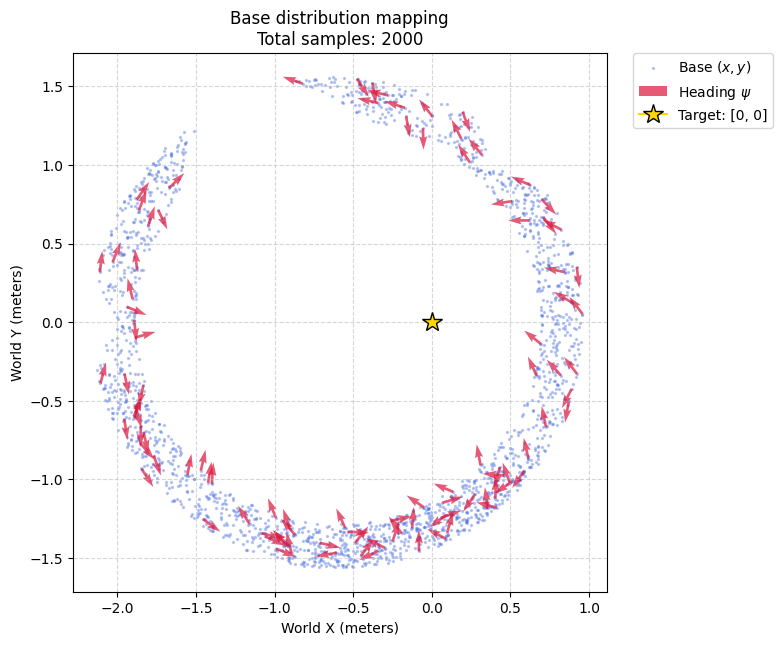

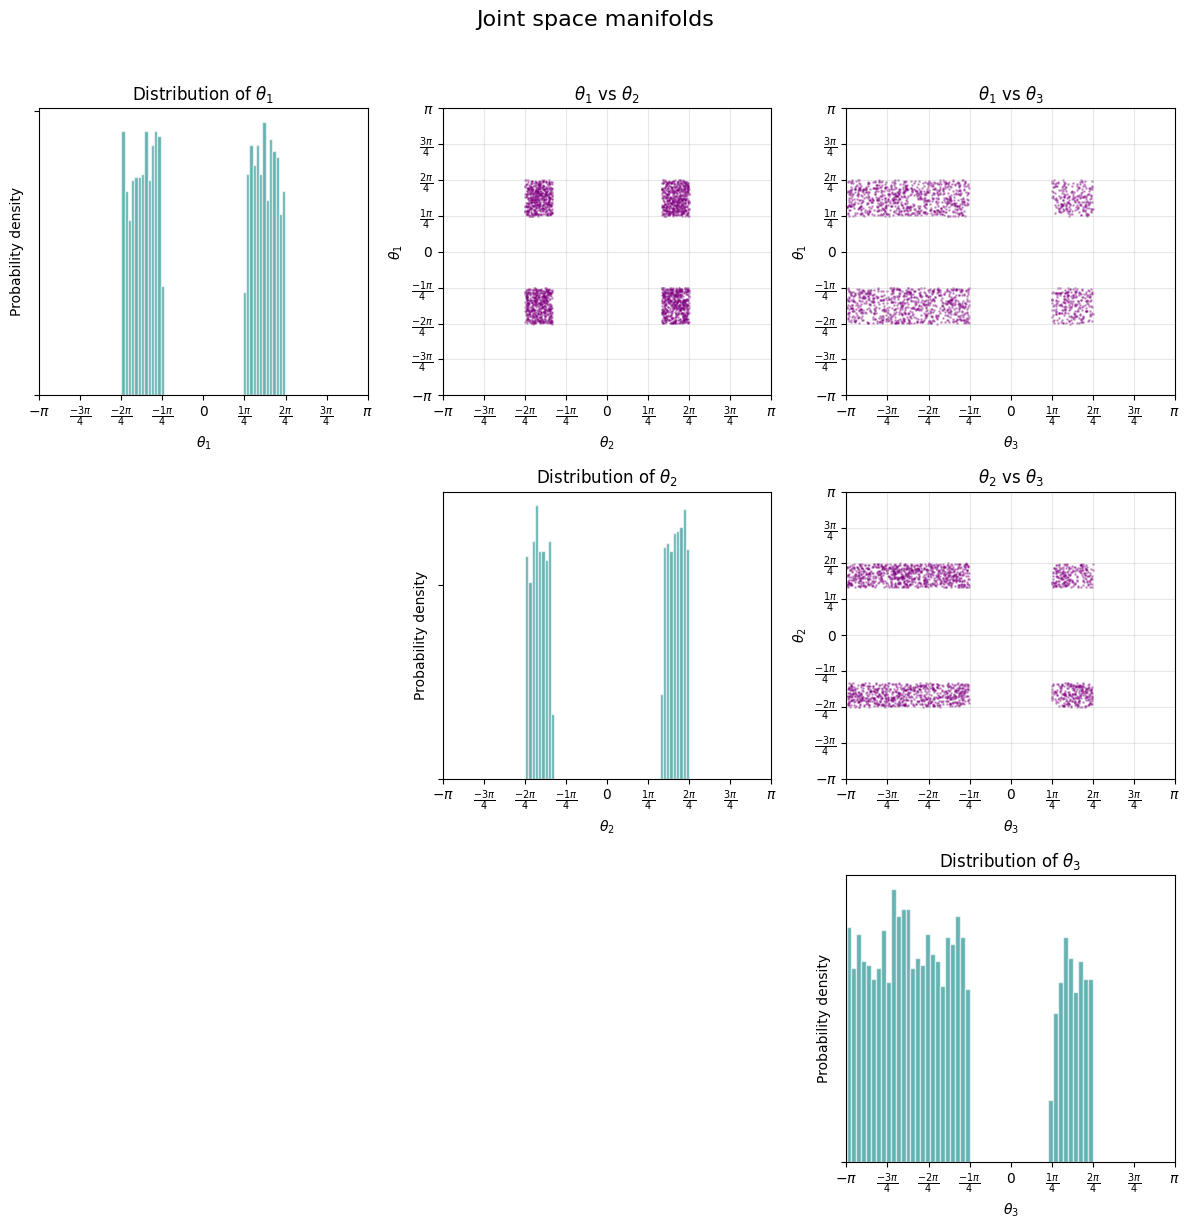

In [9]:
# Data to test on
n_samples = 2000
h_world_example = np.zeros((n_samples, 3), dtype=np.float32)

# 1. Generate 2000 samples for a fixed target at the origin
Q_samples = env.sample_q(h_world_example, rng)

# Extract components for plotting -> Q columns: [x, y, psi, th1, th2]
bx = Q_samples[:, 0]
by = Q_samples[:, 1]
psi = Q_samples[:, 2]
thetas = Q_samples[:, 3:]
from reachability.utils.plotting import plot_data_distribution

plot_data_distribution([0, 0], bx, by, psi, thetas)

In [78]:
Q_samples[0].shape

(6,)

## Model results
### Conditional VAE

num params in encoder =  2119692
num params in decoder =  8437780
inference speed per sample (seconds):  1.9851922988891602e-05


<Axes: title={'center': 'RotaryNLink (N=3)\nBase psi=-149.9° | EE Delta=0.1499'}, xlabel='X (World)', ylabel='Y (World)'>

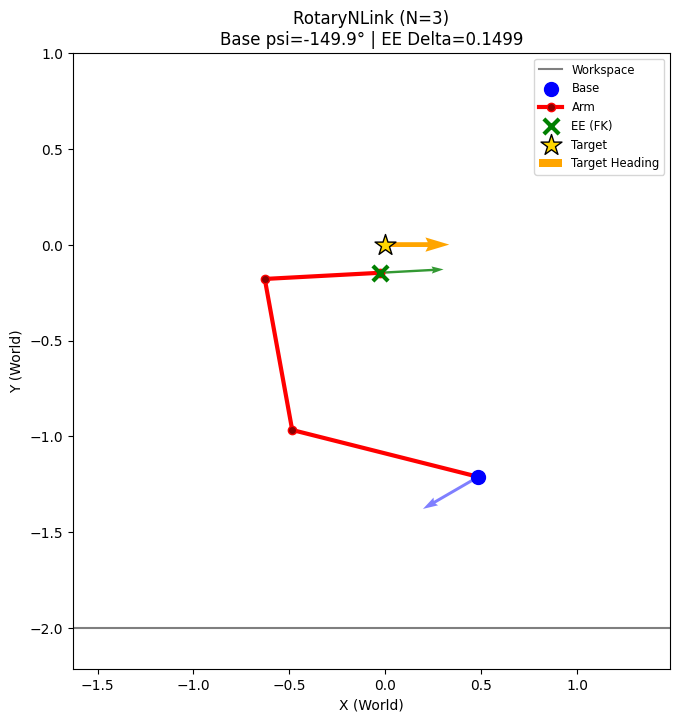

In [13]:
from reachability.models.cvae import CVAEConditionalSampler
cvae_model_path = "outputs/model_ckpts/cvae/cvae_rotaryNlink_1292026.pt"
cvae_model = CVAEConditionalSampler.load(env, cvae_model_path, device="cpu")

# 1. Generate 2000 samples for a fixed target at the origin
start = time.time()
Q_samples = cvae_model.sample(h_world_example, h_world_example, n_samples=1, rng=rng)
print("inference speed per sample (seconds): ", (time.time() - start)/h_world_example.shape[0])
env.plot(Q_samples[0].flatten(), h_world_example.flatten())

In [82]:
print(Q_samples[0].flatten().shape)

(6,)


(2000, 3)


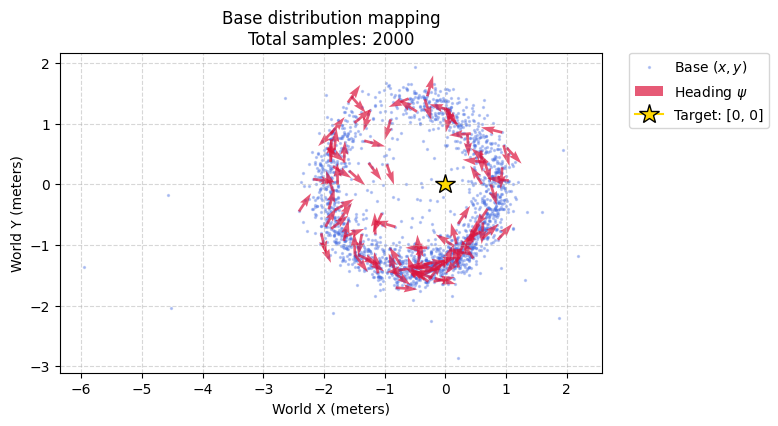

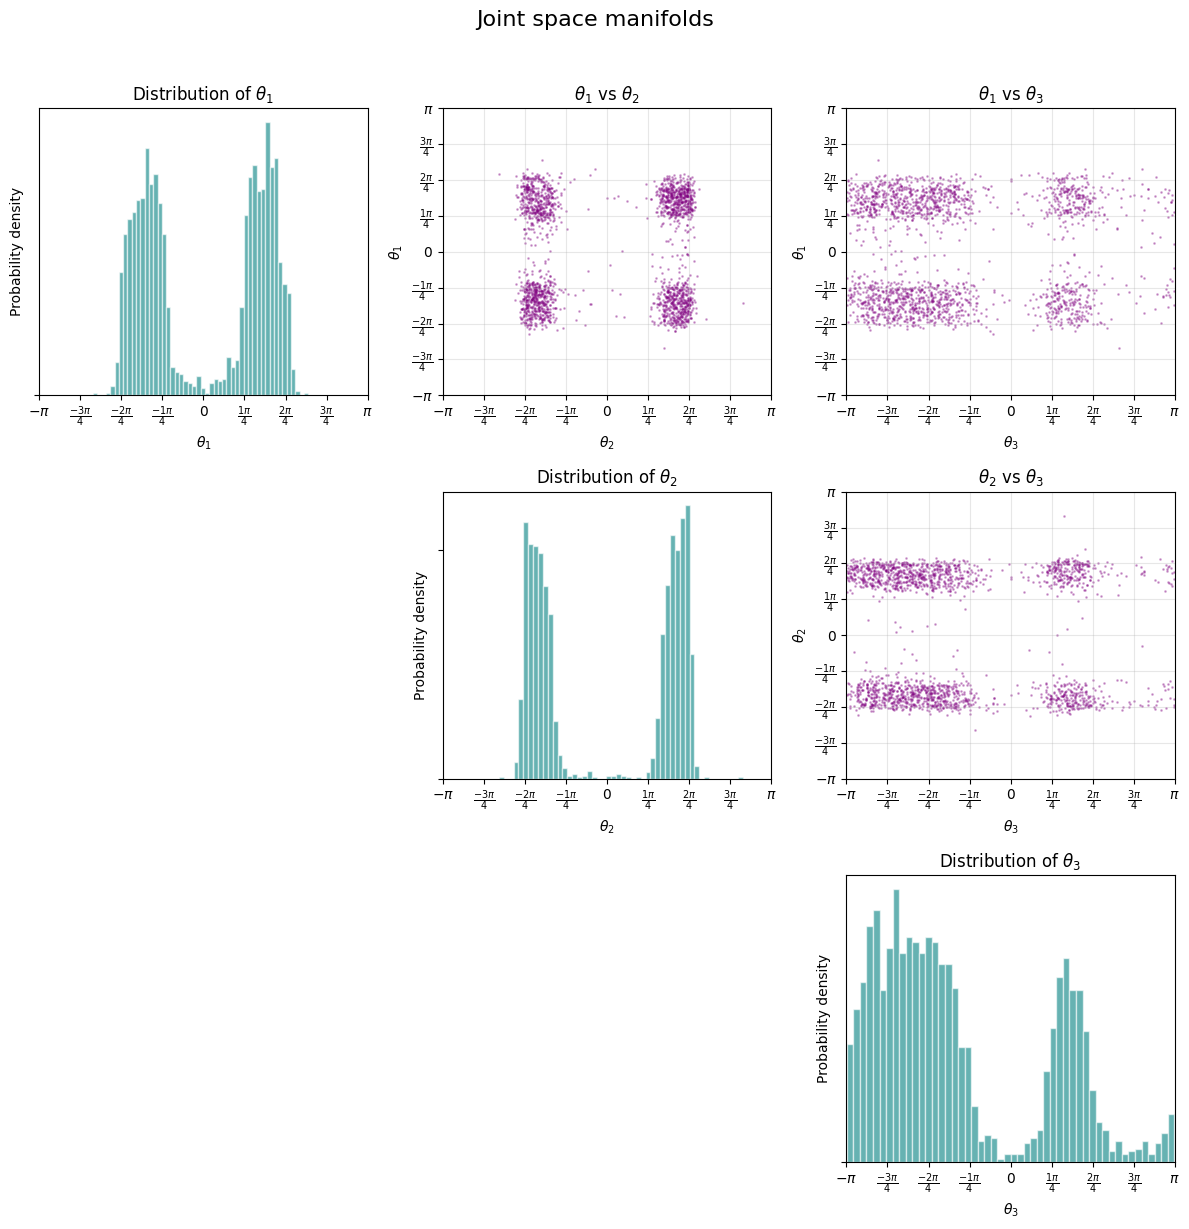

In [75]:
bx = Q_samples[:, :, 0].flatten()
by = Q_samples[:, :, 1].flatten()
psi = Q_samples[:, :, 2].flatten()
thetas = Q_samples[:, :, 3:].reshape(2000, 3)
# print(thetas.shape)
plot_data_distribution([0, 0], bx, by, psi, thetas)

### Conditional INN

DEBUG: q_sample_feat.squeeze(1) shape from model: torch.Size([2000, 10])
DEBUG: q_sample_world shape after conversion: (2000, 6)
inference speed per sample (seconds):  3.2703161239624024e-05


<Axes: title={'center': 'RotaryNLink (N=3)\nBase psi=-157.0° | EE Delta=0.0393'}, xlabel='X (World)', ylabel='Y (World)'>

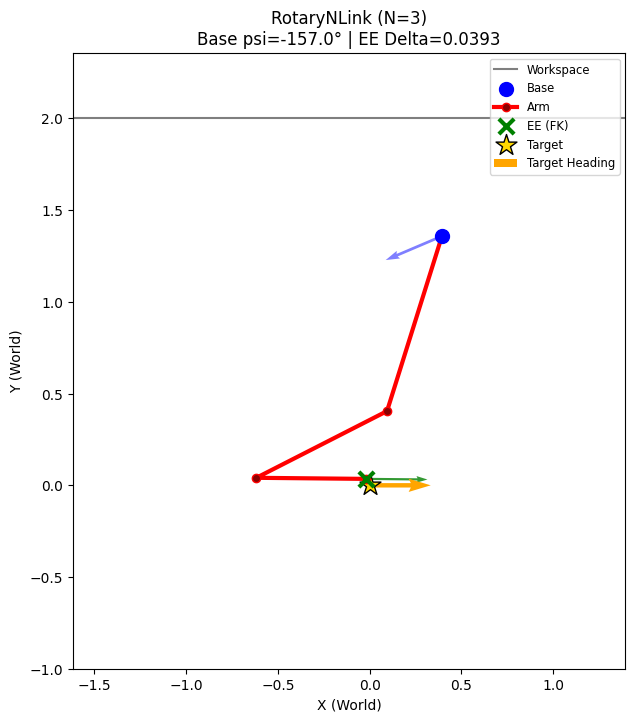

In [15]:
from reachability.models.cinn import CINNConditionalSampler
cinn_model_path = "outputs/model_ckpts/cinn/cinn_rotarynlink_1292026.pt"
cinn_model = CINNConditionalSampler.load(env, cinn_model_path, device="cpu")

# 1. Generate 2000 samples for a fixed target at the origin
start = time.time()
Q_samples = cinn_model.sample(h_world_example, h_world_example, n_samples=1, rng=rng, sampling_temperature=1)
print("inference speed per sample (seconds): ", (time.time() - start)/h_world_example.shape[0])
env.plot(Q_samples[0].flatten(), h_world_example.flatten())

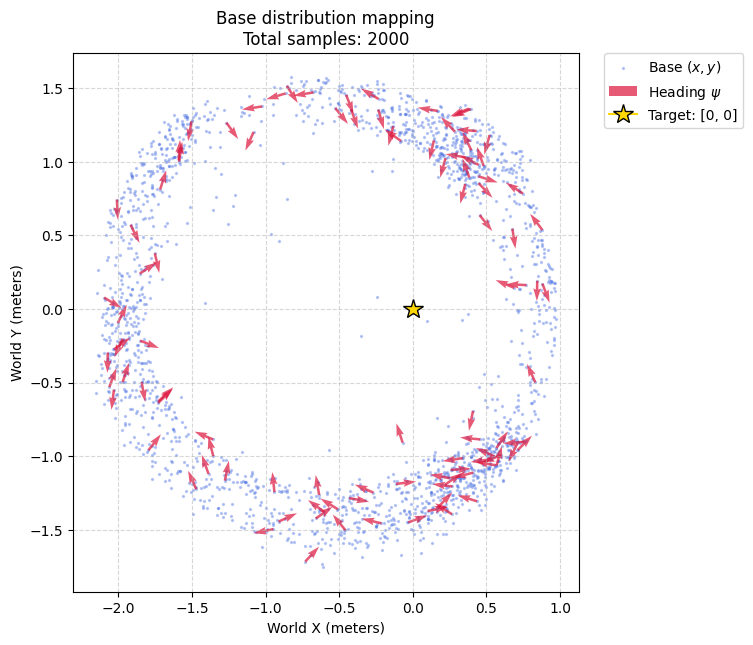

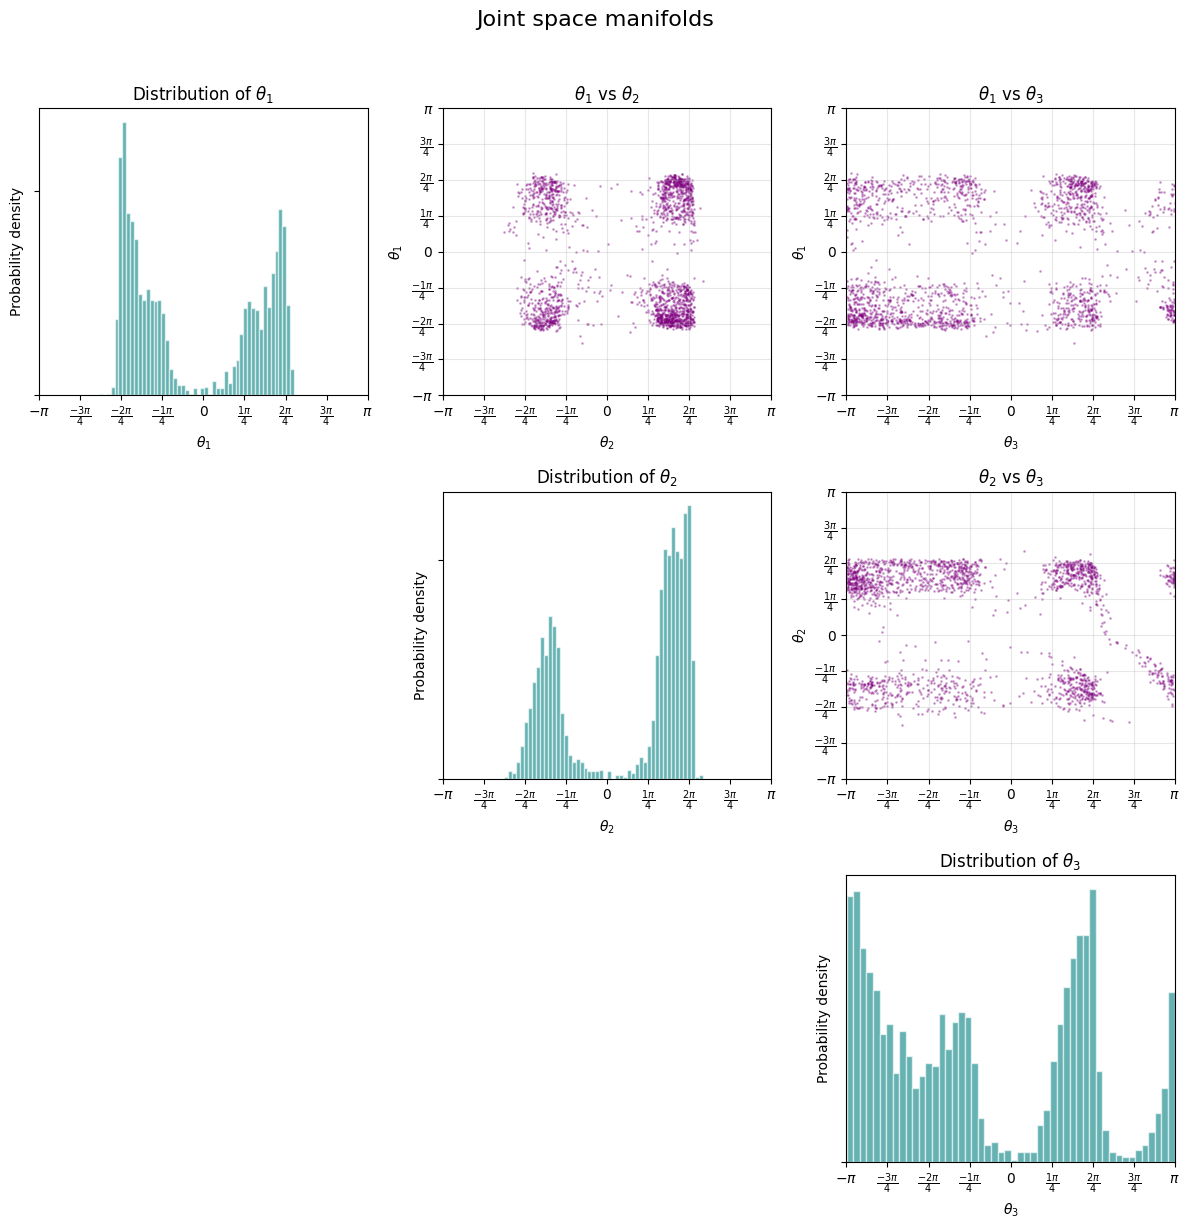

In [16]:
bx = Q_samples[:, :, 0].flatten()
by = Q_samples[:, :, 1].flatten()
psi = Q_samples[:, :, 2].flatten()
thetas = Q_samples[:, :, 3:].reshape(2000, 3)
# print(thetas.shape)
plot_data_distribution([0, 0], bx, by, psi, thetas)

### Conditional diffusion

q_sample_feat shape from model: torch.Size([2000, 10])
q_sample_world shape: (2000, 6)
inference speed per sample (seconds):  0.0008596558570861816


<Axes: title={'center': 'RotaryNLink (N=3)\nBase psi=-153.2° | EE Delta=0.0727'}, xlabel='X (World)', ylabel='Y (World)'>

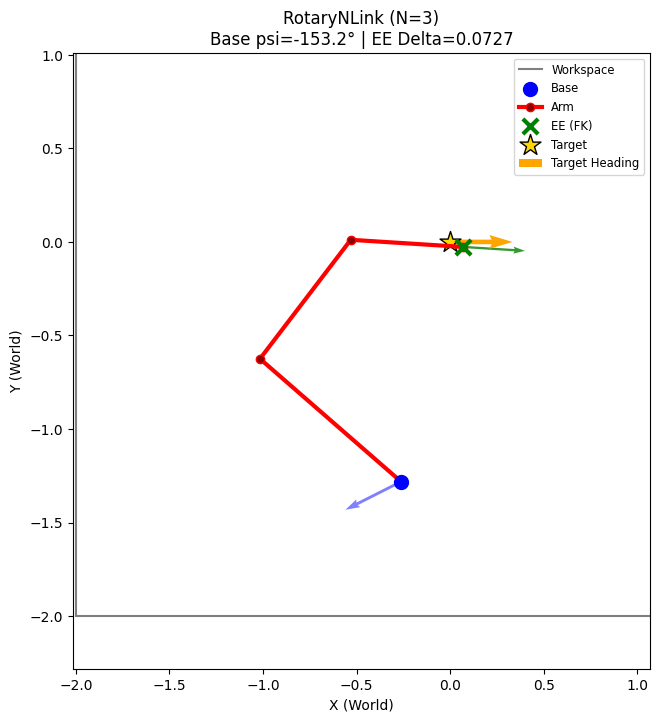

In [30]:
from reachability.models.cdiffusion import DiffusionConditionalSampler
cdiffusion_model_path = "outputs/model_ckpts/cdiffusion/cdiff_rotaryNlink_1292026.pt"
cdiffusion_model = DiffusionConditionalSampler.load(env, cdiffusion_model_path, device="cpu")

start = time.time()
Q_samples = cdiffusion_model.sample(h_world_example, h_world_example, n_samples=1, rng=rng, sampling_temperature=1)
print("inference speed per sample (seconds): ", (time.time() - start)/h_world_example.shape[0])
env.plot(Q_samples[0].flatten(), h_world_example.flatten())

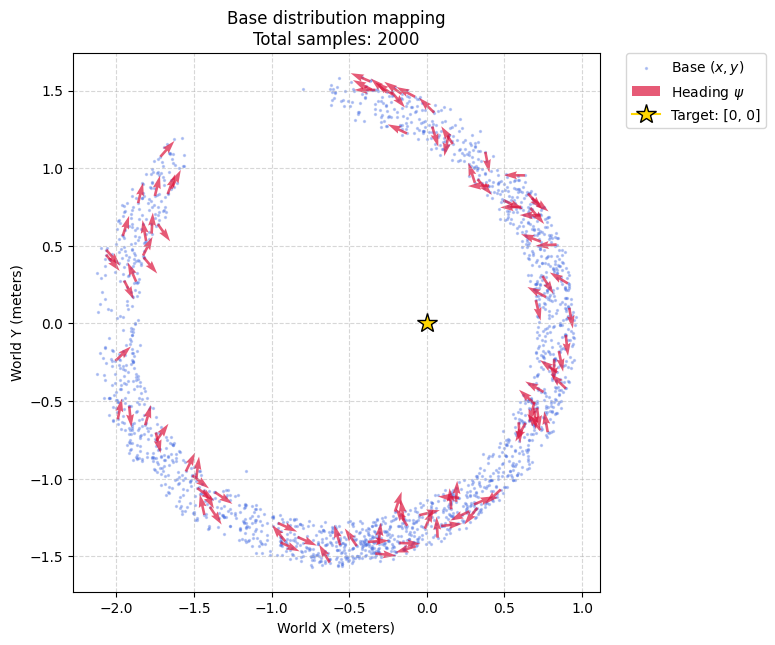

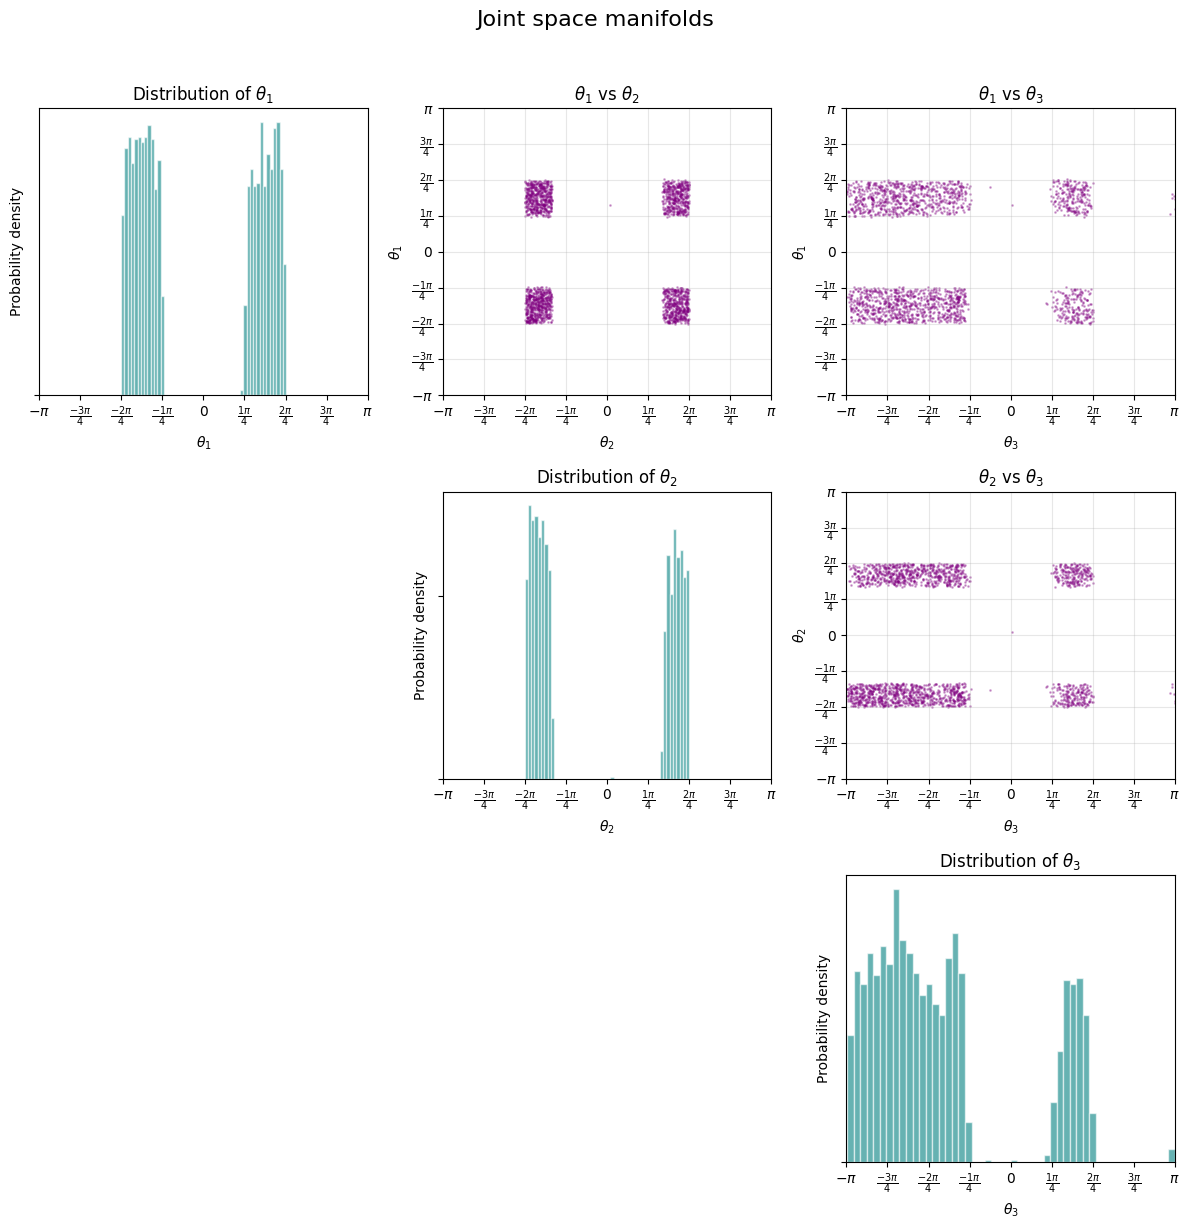

In [18]:
bx = Q_samples[:, :, 0].flatten()
by = Q_samples[:, :, 1].flatten()
psi = Q_samples[:, :, 2].flatten()
thetas = Q_samples[:, :, 3:].reshape(2000, 3)
# print(thetas.shape)
plot_data_distribution([0, 0], bx, by, psi, thetas)

## Comparing all the models -- metrics

In [19]:
print("cVAE num parameters = ", cvae_model.count_parameters())
print("cINN num paramters = ", cinn_model.count_parameters())
print("cDiffusion num parameters = ", cdiffusion_model.count_parameters())

cVAE num parameters =  10557472
cINN num paramters =  8593728
cDiffusion num parameters =  8566154


In [21]:
from reachability.data.datasets import Dataset
from reachability.eval.eval_model import evaluate_model, EvalConfig
n_test = 1000
eval_config = EvalConfig(n_samples_per_h=200, n_bins_theta=72, eps_hist=1.0e-9, sampling_temperature=0)
h_world_test = Dataset.generate(env=env, n=n_test, rng=rng).h_world

In [36]:
print(evaluate_model(env, cvae_model, h_world_test=h_world_test, c_world_test=h_world_test, cfg=eval_config, rng=rng))
print(evaluate_model(env, cinn_model, h_world_test=h_world_test, c_world_test=h_world_test, cfg=eval_config, rng=rng))
print(evaluate_model(env, cdiffusion_model, h_world_test=h_world_test, c_world_test=h_world_test, cfg=eval_config, rng=rng))
# TODO check that eval metrics still make sense for new setup

pos_err shape =  (1000, 200)
{'hand_pos_err/mean': 0.09878509491682053, 'hand_pos_err/median': 0.030698595568537712, 'hand_pos_err/p95': 0.46715354919433594, 'coverage/max_gap_mean': 0.29773861709415755, 'coverage/max_gap_p95': 0.44781259894371006, 'coverage/kl_to_uniform': 0.6933779803272013, 'eval/theta_values': array([ 1.75517201,  2.60360169,  1.02827811, ...,  2.67514443,
       -0.71048617,  2.12773728], shape=(200000,)), 'eval/avg_mmd': np.float64(0.3332141031771898), 'hand_ori_err/mean': 0.05586947128176689, 'hand_ori_err/median': 0.01645466685295105, 'hand_ori_err/p95': 0.24825915694236755}
DEBUG: q_sample_feat.squeeze(1) shape from model: torch.Size([200000, 10])
DEBUG: q_sample_world shape after conversion: (200000, 6)
pos_err shape =  (1000, 200)
{'hand_pos_err/mean': 0.04900018498301506, 'hand_pos_err/median': 0.009718237444758415, 'hand_pos_err/p95': 0.2374131679534912, 'coverage/max_gap_mean': 0.364805867139177, 'coverage/max_gap_p95': 0.5983014257746284, 'coverage/kl_to

In [35]:
print(evaluate_model(env, cvae_model, h_world_test=h_world_test, c_world_test=h_world_test, cfg=eval_config, rng=rng))


pos_err shape =  (1000, 200)
{'hand_pos_err/mean': 0.09828494489192963, 'hand_pos_err/median': 0.030858252197504044, 'hand_pos_err/p95': 0.4635116457939148, 'coverage/max_gap_mean': 0.29484257187030677, 'coverage/max_gap_p95': 0.4487980723381042, 'coverage/kl_to_uniform': 0.6933754069350277, 'eval/theta_values': array([-1.74691665,  2.73610139,  3.08419061, ...,  1.55087972,
        0.80945253, -2.35765386], shape=(200000,)), 'eval/avg_mmd': np.float64(0.3337404832839966), 'hand_ori_err/mean': 0.055336885154247284, 'hand_ori_err/median': 0.016446677967905998, 'hand_ori_err/p95': 0.2473958134651184}


## Random testing

In [52]:
thetas.shape

(2000, 3)

In [60]:
import torch
x = np.array([0, 0, 1])
y = np.array([2, 2, 2])
print(np.concatenate([x, y]))
x = torch.Tensor(x)
y = torch.Tensor(y)
print(torch.stack([x, y], dim=-1))

[0 0 1 2 2 2]
tensor([[0., 2.],
        [0., 2.],
        [1., 2.]])
